# Deep Learning with TensorFlow/Keras

Now that we have completed a project of Machine Learning with spark ML, in this assignment, we will be swithing to the context of Deep Learning with Tensorflow/Keras by two tasks:
- Task1: Image Classification with CNN
- Task2: Image captioning with a combination of CNN and RNN

## Task 1: Going Deeper with convolutions


Before **Inception v1** (**GoogLeNet**), which is the winner of the **ILSVRC** (ImageNet Large Scale Visual Recognition Competition) in 2014, most popular CNNs just stacked convolution layers deeper and deeper, hoping to get better performance.
The Inception network, however, uses a lot of tricks to improve performance in terms of speed and accuracy.
Compared to other networks, **Inception v1** has significant improvement over **ZFNet** (the winner in 2013) and **AlexNet** (the winner in 2012), and has relatively lower error rate compared with the VGGNet.

In this task, we will be implementing the inception architecture [in this paper](https://arxiv.org/abs/1409.4842) with TensorFlow/Keras. 

The goal of this task is to understand how to write code to build the model, as long as you can verify the correctness of the code (e.g., through Keras model summary), it is not necessary to train the model.

References:



https://gist.github.com/joelouismarino/a2ede9ab3928f999575423b9887abd14#file-googlenet-py
           https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.4-tf


In [0]:
cifar10_dataset = tf.keras.datasets.cifar10

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10_dataset.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
print("shape of train x: ", x_train.shape)
print('shape of train y: ', y_train.shape)
print('shape of test x: ', x_test.shape)
print('shape of test y: ', y_test.shape)
print('type of train x: ', x_train.dtype)
print('type of train y: ', y_train.dtype)

shape of train x:  (50000, 32, 32, 3)
shape of train y:  (50000, 1)
shape of test x:  (10000, 32, 32, 3)
shape of test y:  (10000, 1)
type of train x:  uint8
type of train y:  uint8


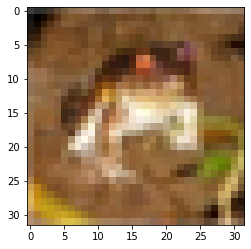

In [0]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
plt.show()

In [0]:
print('Before normalization: ')
print('\t min of train is {}, max of train is {}'.format(np.min(x_train), np.max(x_train)))
print('\t min of test is {}, max of train is {}'.format(np.min(x_test), np.max(x_test)))
x_train = x_train / 255
x_test = x_test / 255

print('After normalization:')
print('\t min of train is {}, max of train is {}'.format(np.min(x_train), np.max(x_train)))
print('\t min of test is {}, max of test is {}'.format(np.min(x_test), np.max(x_test)))

Before normalization: 
	 min of train is 0, max of train is 255
	 min of test is 0, max of train is 255
After normalization:
	 min of train is 0.0, max of train is 1.0
	 min of test is 0.0, max of test is 1.0


In [0]:
print(x_train[0])

[[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509804 0.21568627]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117647 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941176 0.19607843]
  [0.47058824 0.32941176 0.19607843]
  [0.42745098 0.28627451 0.16470588]]

 ...

 [[0.81568627 0.66666667 0.37647059]
  [0.78823529 0.6        0.13333333]
  [0.77647059 0.63137255 0.10196078]
  ...
  [0.62745098 0.52156863 0.2745098 ]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333333 0.07843137]]

 [[0.70588235 0.54509804 0.37647059]
  [0.67843137 0.48235294 0.16470588]


In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD


## Build the Inception-v1 model

In [0]:
def inception(input_tensor, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, 
              Name = None):
    
    conv_1x1 = Conv2D(filters_1x1, (1,1), padding = 'same', activation = 'relu', name = (Name + '/conv_1x1'))(input_tensor)
    
    conv_3x3_reduce = Conv2D(filters_3x3_reduce, (1, 1), padding = 'same', activation = 'relu', name = (Name + '/conv_3x3_reduce'))(input_tensor)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding = 'same', activation = 'relu', name = (Name + '/conv_3x3'))(conv_3x3_reduce)
 
    conv_5x5_reduce = Conv2D(filters_5x5_reduce, (1, 1), padding = 'same', activation = 'relu', name = (Name + '/conv_5x5_reduce'))(input_tensor)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding = 'same', activation = 'relu', name = (Name + '/conv_5x5'))(conv_5x5_reduce)
    
    pool = MaxPooling2D((3, 3), strides = (1, 1), padding = 'same', name = (Name + '/pool'))(input_tensor)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding = 'same', activation = 'relu', name = (Name + '/pool_proj'))(pool)
    
    output = Concatenate(axis = 3, name = (Name + '_output'))([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    return output

In [0]:
#Input layer
input_layer = Input(shape = (224, 224, 3), name = 'input_layer')

#Stem module
conv1_7x7 = Conv2D(64, (7, 7), strides = (2, 2), padding = 'same', activation = 'relu', 
                   name = 'conv1_7x7/s2')(input_layer) 
pool1_3x3 = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same', name = 'pool1/3x3_s2')(conv1_7x7)
conv2_3x3_reduce = Conv2D(64, (1, 1), padding = 'same', activation = 'relu', 
                          name = 'conv2/3x3_reduce')(pool1_3x3)
conv2_3x3 = Conv2D(192, (3, 3), padding = 'same', activation = 'relu', 
                   name = 'conv2/3x3')(conv2_3x3_reduce)
pool2_3x3 = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same', name = 'pool2/3x3_s2')(conv2_3x3)

#Inception 3a & 3b
inception_3a = inception(pool2_3x3, filters_1x1 = 64, filters_3x3_reduce = 96, 
                         filters_3x3 = 128, filters_5x5_reduce = 16, filters_5x5 = 32, 
                         filters_pool_proj = 32, Name = 'incep_3a')
inception_3b = inception(inception_3a, filters_1x1 = 128, filters_3x3_reduce = 128, 
                         filters_3x3 = 192, filters_5x5_reduce = 32, filters_5x5 = 96, 
                         filters_pool_proj = 64, Name = 'incep_3b')

#max pool & inception 4a
pool3_3x3 = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same', name = 'pool3/3x3_s2')(inception_3b)
inception_4a = inception(pool3_3x3, filters_1x1 = 192, filters_3x3_reduce = 96, 
                         filters_3x3 = 208, filters_5x5_reduce = 16, filters_5x5 = 48, 
                         filters_pool_proj = 64, Name = 'incep_4a')


#aux1 brach
aux1_ave_pool = AveragePooling2D((5, 5), strides = (3, 3), name = 'aux1/ave_pool')(inception_4a)
aux1_conv = Conv2D(128, (1, 1), padding = 'same', activation = 'relu', 
                    name = 'aux1/conv')(aux1_ave_pool)
aux1_flat = Flatten()(aux1_conv)
aux1_fc = Dense(1024, activation = 'relu', name = 'aux1/fc')(aux1_flat)
aux1_dropout = Dropout(rate = 0.7)(aux1_fc)
aux1_output = Dense(1000, activation = 'softmax', name = 'aux1/classifier')(aux1_dropout)

#inception 4b & 4c & 4d
inception_4b = inception(inception_4a, filters_1x1 = 160, filters_3x3_reduce = 112, 
                         filters_3x3 = 224, filters_5x5_reduce = 24, filters_5x5 = 64, 
                         filters_pool_proj = 64, Name = 'incep_4b')
inception_4c = inception(inception_4b, filters_1x1 = 128, filters_3x3_reduce = 128, 
                         filters_3x3 = 256, filters_5x5_reduce = 24, filters_5x5 = 64, 
                         filters_pool_proj = 64, Name = 'incep_4c')
inception_4d = inception(inception_4c, filters_1x1 = 112, filters_3x3_reduce = 144, 
                         filters_3x3 = 288, filters_5x5_reduce = 32, filters_5x5 = 64, 
                         filters_pool_proj = 64, Name = 'incep_4d')

#aux2 branch
aux2_ave_pool = AveragePooling2D((5, 5), strides = (3, 3), name = 'aux2/ave_pool')(inception_4d)
aux2_conv = Conv2D(128, (1, 1), padding = 'same', activation = 'relu', 
                    name = 'aux2/conv')(aux2_ave_pool)
aux2_flat = Flatten()(aux2_conv)
aux2_fc = Dense(1024, activation = 'relu', name = 'aux2/fc')(aux2_flat)
aux2_dropout = Dropout(rate = 0.7)(aux2_fc)
aux2_output = Dense(1000, activation = 'softmax', name = 'aux2/classifier')(aux2_dropout)

#inception 4e & max pool
inception_4e = inception(inception_4d, filters_1x1 = 256, filters_3x3_reduce = 160, 
                         filters_3x3 = 320, filters_5x5_reduce = 32, filters_5x5 = 128, 
                         filters_pool_proj = 128, Name = 'incep_4e')
pool4_3x3 = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same', name = 'pool4/3x3_s2')(inception_4e)

#inception 5a & 5b
inception_5a = inception(pool4_3x3, filters_1x1 = 256, filters_3x3_reduce = 160, 
                         filters_3x3 = 320, filters_5x5_reduce = 32, filters_5x5 = 128, 
                         filters_pool_proj = 128, Name = 'incep_5a')

inception_5b = inception(inception_5a, filters_1x1 = 384, filters_3x3_reduce = 192, 
                         filters_3x3 = 384, filters_5x5_reduce = 48, filters_5x5 = 128, 
                         filters_pool_proj = 128, Name = 'incep_5b')

#main output
ave_pool = AveragePooling2D((7, 7), strides = (1, 1), name = 'ave_pool')(inception_5b)
flat = Flatten()(ave_pool)
dropout = Dropout(rate = 0.4)(flat)
output = Dense(1000, activation = 'softmax', name = 'classifier')(dropout)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model = Model(input_layer, [output, aux1_output, aux2_output], name = 'Inception_V1')

#print model layers
model.summary()

#compile model
sgd = SGD(lr = 0.1, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, 
              loss = ["sparse_categorical_crossentropy", "sparse_categorical_crossentropy", "sparse_categorical_crossentropy"], 
              loss_weights = [1, 0.3, 0.3], metrics = ["accuracy"])



Model: "Inception_V1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_7x7/s2 (Conv2D)           (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
pool1/3x3_s2 (MaxPooling2D)     (None, 56, 56, 64)   0           conv1_7x7/s2[0][0]               
__________________________________________________________________________________________________
conv2/3x3_reduce (Conv2D)       (None, 56, 56, 64)   4160        pool1/3x3_s2[0][0]               
_______________________________________________________________________________________

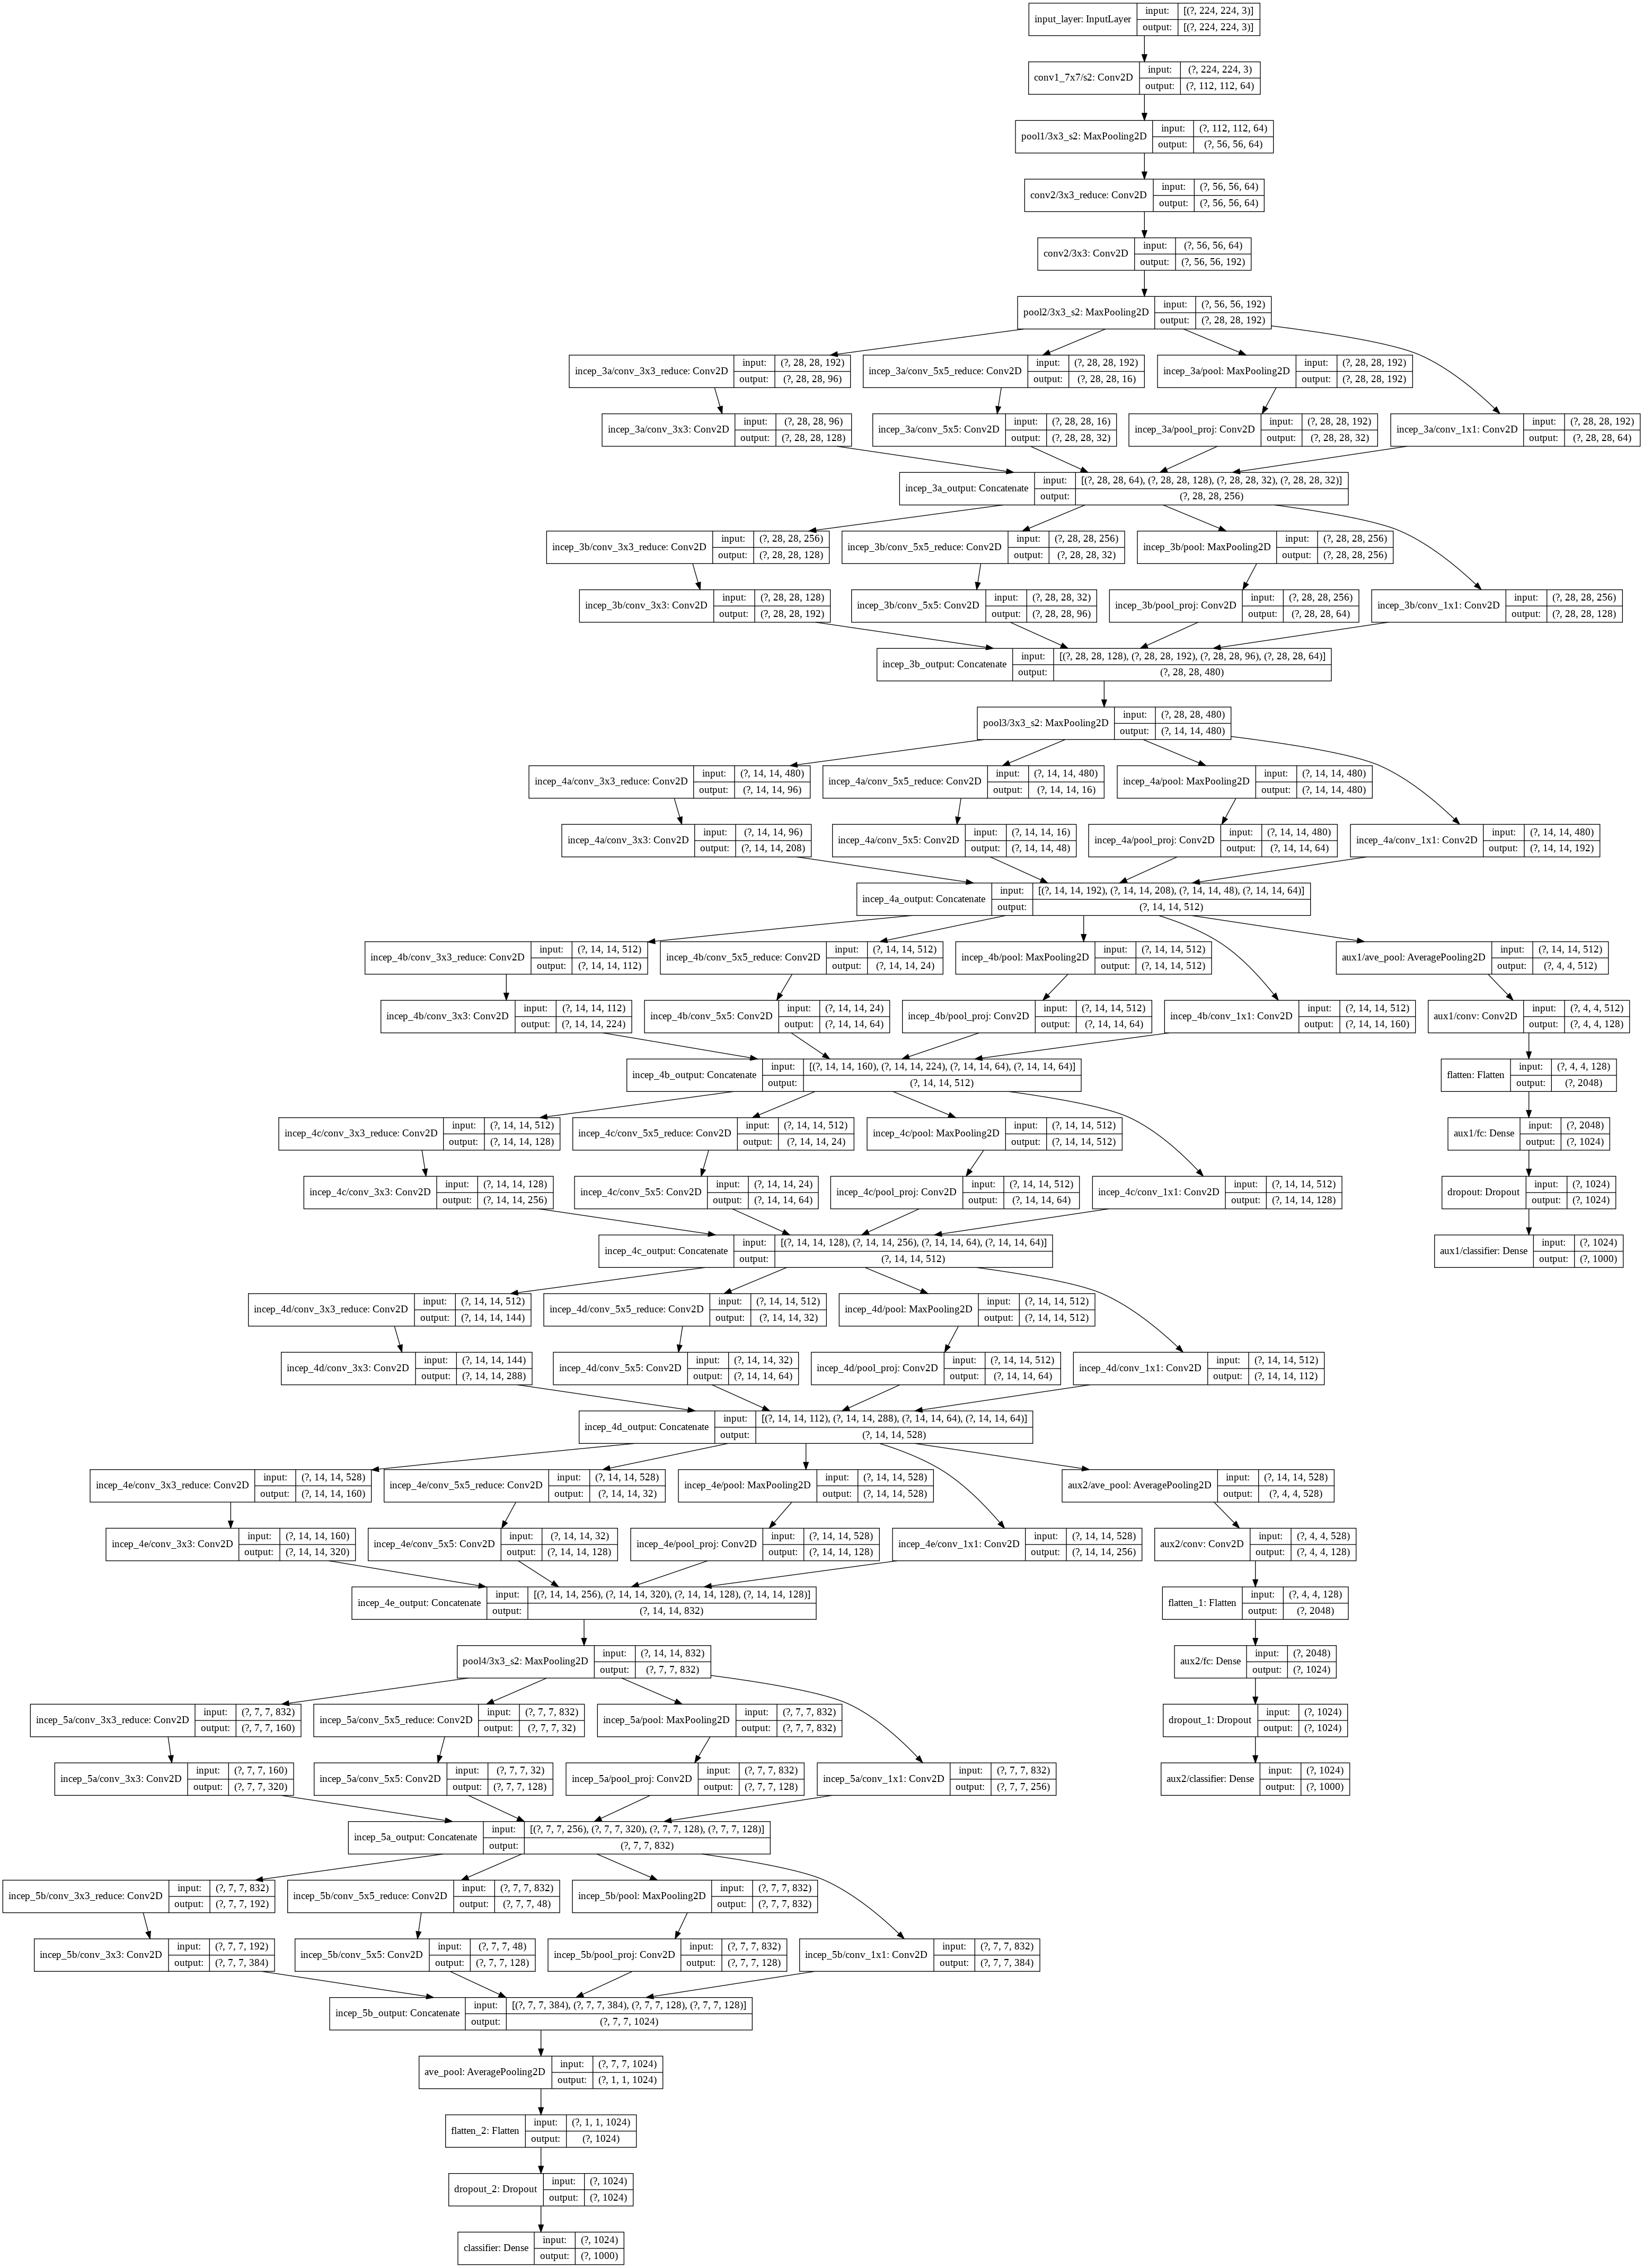

In [0]:
keras.utils.plot_model(model, 'inception_model.png', show_shapes = True)

## Task 2: Show and Tell: A Neural Image Caption Generator

Automatically describing the content of an image is a fundamental problem in AI that connects *computer vision* and *natural language processing*.
In this task, we will be looking into how we can use CNNs and RNNs to build an Image Caption Generator.

Specifically, you will be implementing and training the model [in this paper](https://arxiv.org/abs/1411.4555) with TensorFlow/Keras on one of the datasets mentioned in the paper.

To lighten the burden on training the network, you can use any pretrained network in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

References materials:

https://www.youtube.com/watch?v=NmoW_AYWkb4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN


https://github.com/jeffheaton/t81_558_deep_learning/blob/d118463b72c64cf705ab8abfa9bb75786106f65e/t81_558_class_10_4_captioning.ipynb

### Initialize Google Drive


In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root_captioning = "/content/drive/My Drive/projects/captions"
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Note: using Google CoLab
TensorFlow 2.x selected.


### Import Packages

In [0]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

### Parameter Initialization

In [0]:
START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [0]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

### Data Preprocessing

In [0]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text','Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [0]:
print("unique words: ", len(lookup))
print("dictionary: ", len(lex))
print("Maximum length of a caption (in words): ", max_length) 

unique words:  8092
dictionary:  8763
Maximum length of a caption (in words):  32


#### Glove embedding

In [0]:
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [0]:
print(img)

In [0]:
print(len(img))

8134


In [0]:
train_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)

In [0]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

### Transfer Learning - CNN

In [0]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

96116736/96112376 [==============================] - 1s 0us/step


In [0]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Train_test split

In [0]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [0]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

100%|██████████| 6000/6000 [59:05<00:00,  1.79it/s]



Generating training set took: 0:59:05.80


In [0]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 1000/1000 [09:46<00:00,  1.95it/s]


Generating testing set took: 0:09:46.40


In [0]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [0]:

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [0]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [0]:
max_length +=2
print(max_length)

34


### Data generator

In [0]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [0]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:27, 14773.21it/s]

Found 400000 word vectors.


### build neural network

In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(1652, 200)

In [0]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [0]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Training Phase

In [0]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)

  0%|          | 0/20 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 877s 439ms/step - loss: 4.1213


  5%|▌         | 1/20 [14:37<4:37:47, 877.21s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 878s 439ms/step - loss: 3.4197


 10%|█         | 2/20 [29:15<4:23:13, 877.43s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 877s 438ms/step - loss: 3.2015


 15%|█▌        | 3/20 [43:51<4:08:32, 877.18s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 881s 440ms/step - loss: 3.0672


 20%|██        | 4/20 [58:32<3:54:11, 878.25s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 883s 442ms/step - loss: 2.9714


 25%|██▌       | 5/20 [1:13:15<3:39:55, 879.69s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 886s 443ms/step - loss: 2.9014


 30%|███       | 6/20 [1:28:01<3:25:41, 881.54s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 886s 443ms/step - loss: 2.8436


 35%|███▌      | 7/20 [1:42:47<3:11:19, 883.03s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 889s 445ms/step - loss: 2.7935


 40%|████      | 8/20 [1:57:36<2:56:58, 884.84s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 890s 445ms/step - loss: 2.7544


 45%|████▌     | 9/20 [2:12:27<2:42:31, 886.48s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 880s 440ms/step - loss: 2.7202


 50%|█████     | 10/20 [2:27:07<2:27:26, 884.64s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 882s 441ms/step - loss: 2.6898


 55%|█████▌    | 11/20 [2:41:49<2:12:33, 883.76s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 886s 443ms/step - loss: 2.6638


 60%|██████    | 12/20 [2:56:34<1:57:54, 884.33s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 881s 440ms/step - loss: 2.6433


 65%|██████▌   | 13/20 [3:11:15<1:43:02, 883.21s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 875s 438ms/step - loss: 2.6174


 70%|███████   | 14/20 [3:25:51<1:28:05, 880.88s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 874s 437ms/step - loss: 2.5999


 75%|███████▌  | 15/20 [3:40:24<1:13:13, 878.80s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 876s 438ms/step - loss: 2.5846


 80%|████████  | 16/20 [3:55:01<58:32, 878.07s/it]  

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 874s 437ms/step - loss: 2.5664


 85%|████████▌ | 17/20 [4:09:35<43:50, 876.80s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 865s 433ms/step - loss: 2.5560


 90%|█████████ | 18/20 [4:24:00<29:06, 873.38s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 865s 432ms/step - loss: 2.5390


 95%|█████████▌| 19/20 [4:38:25<14:30, 870.83s/it]

  ...
    to  
  ['...']
Train for 2000 steps
2000/2000 [==============================] - 878s 439ms/step - loss: 2.5285


100%|██████████| 20/20 [4:53:03<00:00, 873.00s/it]

  ...
    to  
  ['...']
Train for 1000 steps


1000/1000 [==============================] - 820s 820ms/step - loss: 2.5117
  ...
    to  
  ['...']
Train for 1000 steps
1000/1000 [==============================] - 789s 789ms/step - loss: 2.4563
  ...
    to  
  ['...']
Train for 1000 steps
1000/1000 [==============================] - 781s 781ms/step - loss: 2.4394
  ...
    to  
  ['...']
Train for 1000 steps
1000/1000 [==============================] - 778s 778ms/step - loss: 2.4279
  ...
    to  
  ['...']
Train for 1000 steps
1000/1000 [==============================] - 780s 780ms/step - loss: 2.4159
  ...
    to  
  ['...']
Train for 1000 steps
1000/1000 [==============================] - 788s 788ms/step - loss: 2.4087
  ...
    to  
  ['...']
Train for 1000 steps
1000/1000 [==============================] - 792s 792ms/step - loss: 2.3993
  ...
    to  
  ['...']
Train for 1000 steps
1000/1000 [==============================] - 792s 792ms/step - loss: 2.3938
  ...
    to  
  ['...']
Train for 1000 steps
1000/1000 [=============

### Generate Captions

In [0]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Evaluation

/content/drive/My Drive/projects/captions/Flicker8k_Dataset/391579205_c8373b5411.jpg


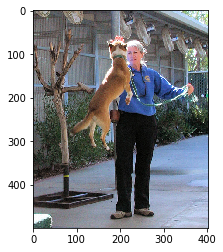

Caption: two children are playing in the street
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/396360611_941e5849a3.jpg


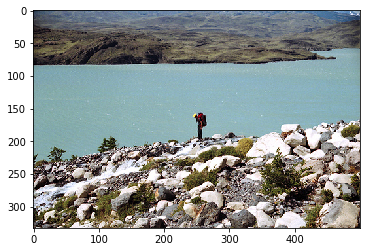

Caption: man is standing on rock looking at the ocean
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/398662202_97e5819b79.jpg


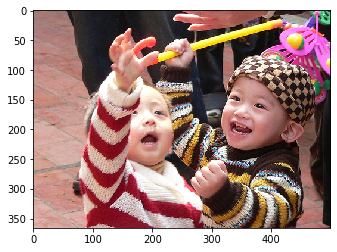

Caption: little girl in pink dress is playing with toy
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/400851260_5911898657.jpg


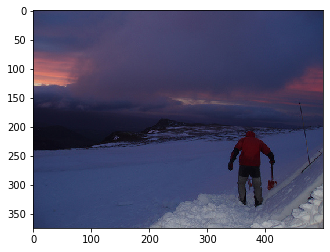

Caption: man is snowboarding down snowy mountainside
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/401079494_562454c4d6.jpg


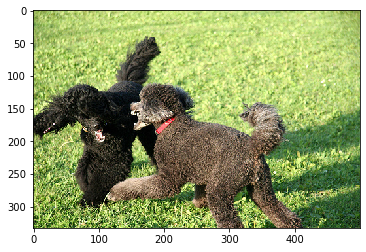

Caption: black poodle is running in the grass
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/405615014_03be7ef618.jpg


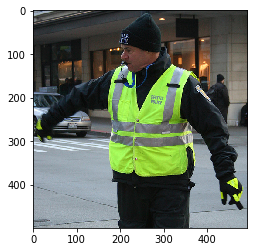

Caption: man in black jacket and hat is standing in front of crowd
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/410453140_5401bf659a.jpg


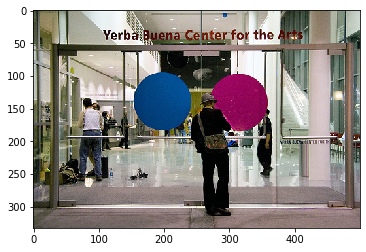

Caption: woman in black and red dress is standing next to tree with her arms crossed
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/415793623_6c1225ae27.jpg


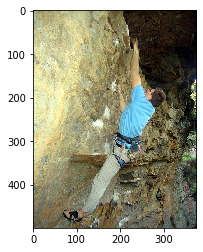

Caption: man in red shirt climbs rock wall
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/416106657_cab2a107a5.jpg


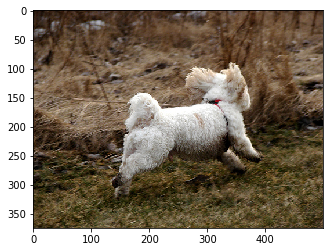

Caption: white dog with black collar is running on the grass
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/416788726_5b4eb1466e.jpg


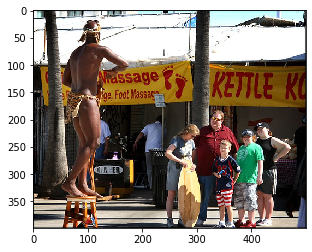

Caption: two women in skimpy outfits are dancing in gym
_____________________________________


In [0]:
for z in range(10):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")